In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from tqdm import tqdm
import scipy.optimize

np.random.seed(2727)

c:\Users\jigna\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Heat Equation with Dirichlet boundary conditions on $[0,T]\times[0,c]$:

\begin{align}
\partial_t u(t,x) &= \partial^2_{xx}u(t,x) \\
u(0,x) &= \varphi(x)\\
u(t,0) &= 0\\
u(t,c) &= 0 
\end{align}

Here time-space is modeled by $(t,x)\in[0,T]\times[0,c]$, thus $u\colon[0,T]\times[0,c]\to \R$


In [8]:
class HeatModel(tf.Module):
    # Heat equation PINN-solver. 
    def __init__(self, layers_size, num_iter, num_data):


        self.T = 0.2
        self.end_point = 2
        self.input_dim = layers_size[0]
        self.layers = layers_size
        self.num_iter = num_iter
        self.num_data = num_data
        # List of tf.Tensor objects
        self.W = []

        # Initializer
        init = tf.initializers.GlorotUniform(seed=2727)

        for i in range(len(layers_size) - 1):
            input_dim = layers_size[i]
            output_dim = layers_size[i + 1]

            w = tf.Variable(init([output_dim, input_dim], dtype='float64'), trainable=True, name=f'w{i+1}')
            b = tf.zeros([output_dim, 1], dtype='float64')
            b = tf.Variable(b, trainable=True, name=f'b{i+1}')

            self.W.append(w)
            self.W.append(b)

        # Learning rate
        self.learning_rate = 0.001
    

    def evaluate(self, x):
        """Evaluates the NN at x.

        Args:
            x : Shape must match the NN input shape.

        Returns:
            tf.Tensor: u_theta(x)
        """
        a = x
        for i in range(len(self.layers) - 2):
            z = tf.add(tf.matmul(self.W[2*i], a), self.W[2*i + 1])
            a = tf.nn.tanh(z)

        a = tf.add(tf.matmul(self.W[-2], a), self.W[-1])
        return a
    
    def init_condition(self, init_data):
        """Initial condition of the PDE.

        Args:
            init_data: data for t=0.

        Returns:
            float: initial condition.
        """
        return init_data[1][0]**2 * (2-init_data[1][0])
    
    def dirichlet_condition(self, dirichlet_data):
        """Function equal to 0 for all t and x=0 and x=c.

        Args:
            dirichlet_data (shape=(2,1)): Of the form [[t],[x]] or [[t],[c]].

        Returns:
            The model evaluated at dirichlet_data.
        """
        v = dirichlet_data[1][0]
        if v not in [0, self.end_point]:
            raise Exception("Dirichlet condition no defined for x={}".format(v))
        else:
            return 0
    ##################### LOSS METHODS ###########################

    def dirichlet_condition_loss(self, dirichlet_data):
        weight = self.T / self.num_data
        return weight * tf.square(self.evaluate(dirichlet_data))

    def initial_condition_loss(self, init_data):
        weight = self.end_point / self.num_data
        return weight * tf.square(tf.subtract(self.evaluate(init_data), self.init_condition(init_data)))

    def pde_loss(self, interior_data):

        # Error given by the PDE over data_set.
        
        z = tf.reshape(tf.Variable(interior_data, trainable=False), (self.input_dim,1))
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape1:
                tape1.watch(z)
                u = self.evaluate(z)
            u_z = tape1.gradient(u, z)
            tape2.watch(z)
        u_zz = tape2.gradient(u_z, z)

        u_t = tf.reshape(u_z[0], (1,1))
        u_xx = tf.reshape(u_zz[1], (1,1))
        
        weigth = ((self.T * self.end_point) / self.num_data)
        return weigth * tf.square(tf.subtract(u_t, 4 * u_xx))


    def total_loss(self, init_data, interior_data, dirichlet_data_0, dirichlet_data_c):
        """Computes the loss at init_data and interior_data.

        Args:
            every particular data point must have shape (2,1).

        Returns:
            loss at the current data point.
        """

        return self.initial_condition_loss(init_data)\
                    + self.dirichlet_condition_loss(dirichlet_data_0)\
                    + self.dirichlet_condition_loss(dirichlet_data_c)\
                    + self.pde_loss(interior_data)

    ##################### TRAINING METHODS ###########################


    def apply_gradients(self, gradients_list: list):
        """Updates the parameters according to SGD iteration.

        Args:
            gradients_list (list): list of tf.Tensor
        """
        for g, p in zip(gradients_list, self.W):
            p = p.assign_sub(self.learning_rate * g)
    
    
    def train(self):
        num_iter = self.num_iter
        num_data = self.num_data
        T = self.T
        c = self.end_point
        init_data = [[[0], [x]] for x in np.random.uniform(0,c,num_data)]
        dirichlet_data_0 = [[[t],[0]] for t in np.random.uniform(0,T,num_data)]
        dirichlet_data_c = [[[t],[c]] for t in np.random.uniform(0,T,num_data)]
        interior_data = [[[t], [x]] for t,x in zip(np.random.uniform(0,T,num_data), np.random.uniform(0,c,num_data))]
        #full_data = zip(init_data, interior_data, dirichlet_data_0, dirichlet_data_c)
        loss = []
        for _ in tqdm(range(num_iter)):
            j = np.random.randint(num_data)
            with tf.GradientTape() as tape:
                tape.watch(self.W)
                target = self.total_loss(init_data[j], interior_data[j], dirichlet_data_0[j], dirichlet_data_c[j])
                #target = self.initial_condition_loss(init_data[j])
            grads = tape.gradient(target, self.W)
            self.apply_gradients(grads)
            loss.append(target)
            #opt.apply_gradients(zip(grads, self.W))
        return loss

            

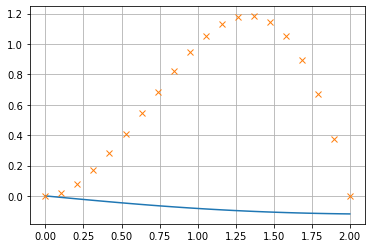

In [9]:
# Create model with input dimension 2 (t,x) and output dimension 1.
d=32
model = HeatModel(layers_size=[2,d,d,d,d,d,d,1], num_iter=5000, num_data=1000)
# plot model for t=0
x = np.linspace(0,2,30)
y = [model.evaluate([[0],[v]])[0][0].numpy() for v in x]
plt.plot(x,y)
x = np.linspace(0,2,20)
plt.plot(x, x**2*(2-x), 'x')
plt.grid()

In [10]:
loss = model.train()


100%|██████████| 5000/5000 [02:31<00:00, 32.97it/s]


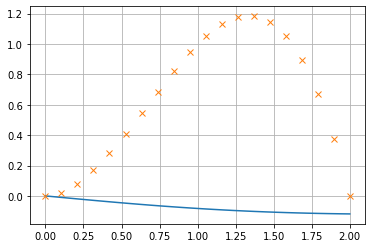

In [5]:
x = np.linspace(0,2,30)
y = [model.evaluate([[0],[v]])[0][0].numpy() for v in x]
plt.plot(x,y)
x = np.linspace(0,2,20)
plt.plot(x, x**2*(2-x), 'x')
plt.grid()

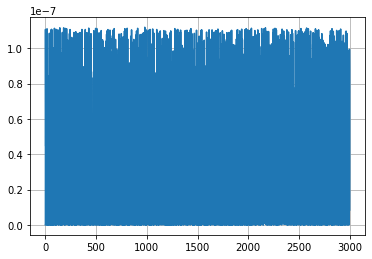

In [6]:
loss = list(map(lambda v: v[0][0].numpy(), loss))
plt.plot(loss)
plt.grid()

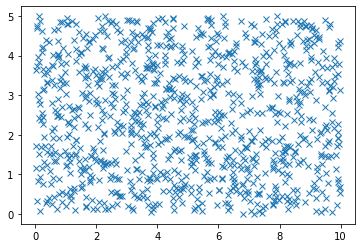

In [94]:
x = np.random.uniform(0,10,1000)
y = np.random.uniform(0,5,1000)
plt.plot(x, y, 'x')
